# Cecilia Benedetti - ISM for mutation effect prediction

# DATA PREPROCESSING

In [ ]:
import numpy as np
from collections import defaultdict
import sys
import argparse
import re
import pandas as pd
import numpy as np
from sklearn import metrics
import os
import random
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import statistics

### CHECK FOR MISSING DATA

In [2]:
MSA = []
path_of_the_directory= 'Data'
for filename in os.listdir('Data'):
    f = os.path.join(path_of_the_directory,filename)
    name = str(f)[5:-8]
    MSA.append(name)

Mut = []
path_of_the_directory_mutation= 'Mutations'
for filename in os.listdir(path_of_the_directory_mutation):
    f = os.path.join(path_of_the_directory,filename)
    name = str(f)[5:-4]
    Mut.append(name)

In [3]:
MSA = set(MSA)
Mut = set(Mut)
missing_values_Mut= MSA-Mut
missing_values_Mut

{'ARMC4_HUMAN',
 'BRCA1_BRCT_HUMAN_1620_1856',
 'BRCA1_HUMAN_',
 'BRCA1_RING_HUMAN_1_110',
 'CASK_HUMAN',
 'CC114_HUMAN',
 'CRYA2_HUMAN',
 'DVLP1_HUMAN',
 'H2A1_HUMAN',
 'H31_HUMAN',
 'KHD3L_HUMAN',
 'SIAS_HUMAN',
 'SMN_HUMAN'}

all values relative to BRCA1 are erroneusly there

In [4]:
missing_values_Mut.remove('BRCA1_BRCT_HUMAN_1620_1856')
missing_values_Mut.remove('BRCA1_HUMAN_')
missing_values_Mut.remove('BRCA1_RING_HUMAN_1_110')

In [5]:
missing_values_Mut

{'ARMC4_HUMAN',
 'CASK_HUMAN',
 'CC114_HUMAN',
 'CRYA2_HUMAN',
 'DVLP1_HUMAN',
 'H2A1_HUMAN',
 'H31_HUMAN',
 'KHD3L_HUMAN',
 'SIAS_HUMAN',
 'SMN_HUMAN'}

In [6]:
missing_values_MSA = Mut-MSA
missing_values_MSA
missing_values_MSA.remove('BRCA1_BRCT_HUMAN')
missing_values_MSA.remove('BRCA1_HUMAN')
missing_values_MSA.remove('BRCA1_RING_HUMAN')
missing_values_MSA

{'ADRB2_HUMAN'}

Check missing values in the two datasets 

### MUTATION TABLE

Check that every mutation has at least 5 pathogenic and 5 benign labels

In [7]:
df_to_concat = []
store_mut_name =[]
x = 0
directory= 'Mutations'
for file in os.listdir(directory): 
    x+=1 
    name = file[:-4]
    mutation = os.path.join(directory,file)
    df_m = pd.read_csv(mutation, low_memory = False)
    df_m = df_m.iloc[:,[0,1,2,6,10,37]]
    df_m = df_m.dropna()
    l = [name for i in range(len(df_m))]
    
    
    counts = dict(df_m['Starred_Coarse_Grained_Clin_Sig'].value_counts())
       
    if ('benign' in counts.keys()) == False:
        continue
    if ('pathogenic' in counts.keys()) == False:
        continue 
    benign = counts['benign']
    pathogenic = counts['pathogenic']
    if benign < 5: 
        continue
    elif pathogenic<5: 
        continue
    df_m.insert(0, 'gene name', l)
    #df_m = df_m[df_m.iloc[:,4]!='uncertain']

    df_to_concat.append(df_m)
mutation = pd.concat(df_to_concat, ignore_index=True, axis=0)
mutation = mutation.rename(columns={"Starred_Coarse_Grained_Clin_Sig": 'ClinVar'})
mutation = mutation.rename(columns={"EVE_scores_ASM": 'EVEscore'})
mutation = mutation.rename(columns={"coarse_clinical_significance_post": 'EVElabels'})
mutation

,gene name,wt_aa,position,mt_aa,ClinVar,EVEscore,EVElabels
0,3BP2_HUMAN,E,5,D,uncertain,0.415034,uncertain
1,3BP2_HUMAN,P,9,L,uncertain,0.584747,uncertain
2,3BP2_HUMAN,P,11,L,uncertain,0.584015,uncertain
3,3BP2_HUMAN,M,12,V,uncertain,0.623479,uncertain
4,3BP2_HUMAN,G,16,R,uncertain,0.628165,uncertain
...,...,...,...,...,...,...,...
273691,ZEB2_HUMAN,S,1189,F,uncertain,0.417064,uncertain
273692,ZEB2_HUMAN,S,1189,P,uncertain,0.125278,uncertain
273693,ZEB2_HUMAN,M,1190,T,uncertain,0.398900,uncertain
273694,ZEB2_HUMAN,D,1192,A,uncertain,0.289542,uncertain


In [8]:
len(mutation['gene name'].unique())

354

In [9]:
g_names = mutation['gene name'].unique()

### Removal of NaN and 'uncertain' values 

In [10]:
uncertain,pathogenic, benign = mutation['ClinVar'].value_counts()

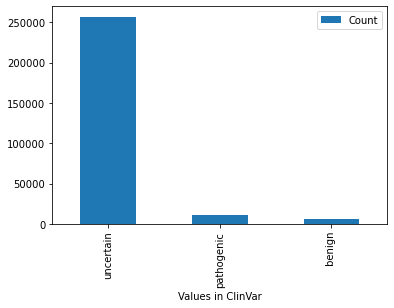

In [11]:
df = pd.DataFrame({'Values in ClinVar':['uncertain','pathogenic',' benign'], 'Count':[uncertain,pathogenic,benign]})
ax = df.plot.bar(x='Values in ClinVar', y='Count')

In [12]:
uncertain + benign + pathogenic

273696

In [13]:
uncertain

257023

In [14]:
pathogenic

10694

In [15]:
benign

5979

In [16]:
uncertain/benign

42.987623348386016

In [17]:
uncertain/pathogenic

24.034318309332335

In [18]:
uncertain/len((mutation))

0.9390820472348883

uncertain values accounts for the 94% of ClinVar labels, we remove them

In [19]:
mutation = mutation[mutation['ClinVar']!='uncertain']
mutation.index = [i for i in range(len(mutation))]

In [20]:
pathogenic, benign = mutation['ClinVar'].value_counts()

In [21]:
len(mutation['gene name'].unique())

354

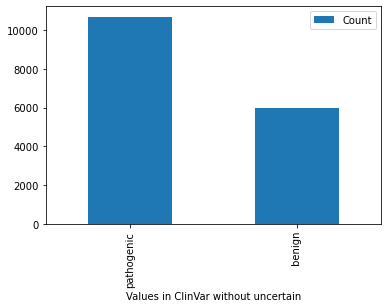

In [22]:
df = pd.DataFrame({'Values in ClinVar without uncertain':['pathogenic',' benign'], 'Count':[pathogenic,benign]})
ax = df.plot.bar(x='Values in ClinVar without uncertain', y='Count')

In [23]:
mutation

,gene name,wt_aa,position,mt_aa,ClinVar,EVEscore,EVElabels
0,3BP2_HUMAN,V,27,M,benign,0.630466,benign
1,3BP2_HUMAN,R,56,C,benign,0.151390,benign
2,3BP2_HUMAN,R,80,Q,benign,0.622594,benign
3,3BP2_HUMAN,H,100,R,benign,0.616032,benign
4,3BP2_HUMAN,A,155,V,benign,0.127663,benign
...,...,...,...,...,...,...,...
16668,ZEB2_HUMAN,L,1113,M,benign,0.729841,uncertain
16669,ZEB2_HUMAN,P,1118,H,benign,0.772766,uncertain
16670,ZEB2_HUMAN,L,1151,P,benign,0.373573,benign
16671,ZEB2_HUMAN,I,1179,T,benign,0.128273,benign


# INDEPENDENT MODEL

In [24]:
def read_fasta(fasta_path, alphabet='ACDEFGHIKLMNPQRSTVWY-', default_index=20):
    
    seq_dict = {}
    with open(fasta_path, 'r') as file_handle:
        seq_id = None
        for line in file_handle:
            line = line.strip()
            if line.startswith(">"):
                seq_id = line
                seq_dict[seq_id] = ""
                continue
            assert seq_id is not None
            line = ''.join([c for c in line if c.isupper() or c == '-'])
            seq_dict[seq_id] += line
            

    aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
    seq_msa = []
    keys_list = []
    for k in seq_dict.keys():
        seq_msa.append([aa_index[s] for s in seq_dict[k]])
        keys_list.append(k)
    seq_msa = np.array(seq_msa, dtype=int)

    return seq_msa.astype(np.uint8), len(alphabet)

In [25]:
path_of_the_directory= 'Data'
dict_filename= {}
for f in os.listdir(path_of_the_directory):
    if str(f)[:5]!='BRCA1':
        name = str(f)[:-8]
    else: 
        if str(f)[:11] == 'BRCA1_HUMAN': 
            name = 'BRCA1_HUMAN'
        elif str(f)[:10] == 'BRCA1_BRCT': 
            name = 'BRCA1_BRCT_HUMAN'
        elif str(f)[:10] == 'BRCA1_RING': 
            name = 'BRCA1_RING_HUMAN'
    dict_filename[name] = f

In [26]:
data={}
length = {}
alpha = 0.0001
for gene in g_names: 
    filename = dict_filename[gene]
    f = os.path.join(path_of_the_directory,filename)
    data_in = read_fasta(f)
    seq_msa, q = data_in
    M,N = seq_msa.shape
    freq = np.zeros((N,q))
    for m in range(M): 
        for n in range(N): 
            freq[n,seq_msa[m,n]] +=1
    freq = freq/M
    data[gene] = freq*(1-alpha) + alpha*(1/q)
    length[gene] = M

In [27]:
keys = list(data.keys())

Check sum of the frequences equal to 1

In [28]:
np.sum(data[keys[0]], axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

### REFERENCE SEQUENCES 

Store the reference sequence

In [29]:
path_of_the_directory= 'Data'
reference_sequences={}
for gene in keys: 
    name = dict_filename[gene]
    f = os.path.join('Data',name)
    with open(f, 'r') as file_handle:
        seq_regex=''
        file_handle.readline()
        for line in file_handle:
            if line.startswith(">"):
                break
            else: 
                seq_regex+=line.strip()
        reference_sequences[gene] = seq_regex

### H MATRIX

In [31]:
def createH(f_sequence):
    return np.log(f_sequence)

In [32]:
H = {}
for key in data.keys():
    H[key] = createH(data[key])

### ADD MUTATIONS

In [34]:
def seq_to_num(sequence, alphabet='ACDEFGHIKLMNPQRSTVWY-', default_index=20):
    aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
    
    seq_msa = []
    line = ''.join([c for c in sequence if c.isupper() or c == '-'])
    
    seq_msa.append([aa_index[s] for s in line])

    return seq_msa[0]

In [35]:
def calculatep(gene, sequence_str):
    prob_s=0
    sequence = seq_to_num(sequence_str)
    for i in range(len(sequence)):
        prob_s += H[gene][i][sequence[i]]
    return prob_s
    

Calculate the probability for each reference sequence

In [103]:
prob_s = {}
for seq in reference_sequences.keys(): 
    prob_s[seq] = calculatep(seq, reference_sequences[seq])

Calculate probability mutations

In [37]:
mutated_sequence_score= []
for gene in g_names:
    g_table =  mutation[mutation['gene name'] == gene]
    g_table.index = [i for  i in range(len(g_table))]

    if gene != 'BRCA1_BRCT_HUMAN':
        for i in range(len(g_table)):
            seq = reference_sequences[gene]
            mutated_sequence = seq

            if seq[g_table['position'][i] -1].isupper() == False:
                #   #letter = g_table['mt_aa'][i].lower()
                mutated_sequence_score.append('to be dropped')
                pass
            else: 
                letter = g_table['mt_aa'][i]
                mutated_sequence = seq[:g_table['position'][i]-1] + letter + seq[g_table['position'][i]:]

            #apply the mutation
                mutated_s = seq_to_num(mutated_sequence)
            #evaluate probability 
                prob_s_mutated=0
                for j in range(len(mutated_s)):
                    prob_s_mutated += H[gene][j][mutated_s[j]]
                    prob_s_mutated
            #difference in probability
                delta = prob_s[gene] - prob_s_mutated
                mutated_sequence_score.append(delta)
    else: 
        for i in range(len(g_table)):
            seq = reference_sequences[gene]
            mutated_sequence = seq

            if seq[g_table['position'][i] - 1621].isupper() == False:
                #letter = g_table['mt_aa'][i].lower()
                mutated_sequence_score.append('to be dropped')
                pass
            else: 
                letter = g_table['mt_aa'][i]
                mutated_sequence = seq[:g_table['position'][i] - 1621] + letter + seq[g_table['position'][i]-1620:]

        #apply the mutation
                mutated_s = seq_to_num(mutated_sequence)
        #evaluate probability 
                prob_s_mutated=0
                for j in range(len(mutated_s)):
                    prob_s_mutated += H[gene][j][mutated_s[j]]
                    prob_s_mutated
        #difference in probability
                delta = prob_s[gene] - prob_s_mutated
                mutated_sequence_score.append(delta)

In [39]:
mutation.insert(7,'score',mutated_sequence_score)
mutation

,gene name,wt_aa,position,mt_aa,ClinVar,EVEscore,EVElabels,score
0,3BP2_HUMAN,V,27,M,benign,0.630466,benign,12.218294
1,3BP2_HUMAN,R,56,C,benign,0.151390,benign,5.746085
2,3BP2_HUMAN,R,80,Q,benign,0.622594,benign,12.234506
3,3BP2_HUMAN,H,100,R,benign,0.616032,benign,12.230111
4,3BP2_HUMAN,A,155,V,benign,0.127663,benign,5.035303
...,...,...,...,...,...,...,...,...
16668,ZEB2_HUMAN,L,1113,M,benign,0.729841,uncertain,6.193989
16669,ZEB2_HUMAN,P,1118,H,benign,0.772766,uncertain,3.801105
16670,ZEB2_HUMAN,L,1151,P,benign,0.373573,benign,6.935022
16671,ZEB2_HUMAN,I,1179,T,benign,0.128273,benign,2.154461


### Data visualization

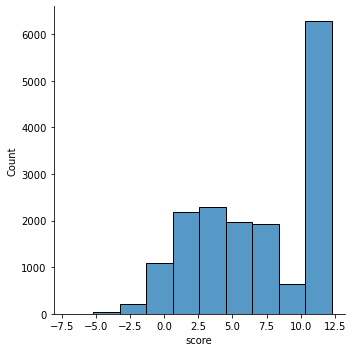

In [40]:
sns.displot(mutation, x="score",bins=10)

In [41]:
mutation['score'].describe()

count    16673.000000
mean         7.055690
std          4.520695
min         -7.115327
25%          3.077327
50%          7.007091
75%         12.092354
max         12.254768
Name: score, dtype: float64

In [42]:
len(mutation[mutation['score']>11]) / len(mutation)

0.3662208360822887

In [43]:
pathog = list(mutation[mutation['ClinVar'] == 'pathogenic']['score'])

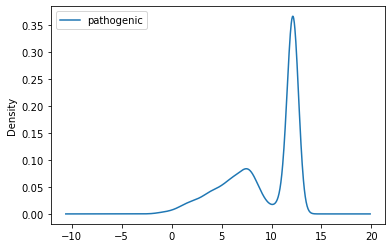

In [44]:
df = pd.DataFrame({
    'pathogenic': pathog,
})
ax = df.plot.kde()

In [45]:
ben = list(mutation[mutation['ClinVar'] == 'benign']['score'])

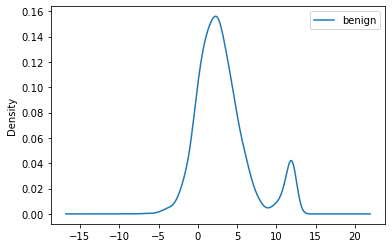

In [46]:
df2 = pd.DataFrame({
    'benign': ben,
})
ax = df2.plot.kde()

# RESULTS

## AUC EVE

In [47]:
AUC = pd.read_excel ('AUC.xlsx')
AUC= AUC.iloc[:,[0,2]] 
index=[]
for i in range(len(AUC)): 
    if AUC['pid'][i] in g_names:
        index.append(i)
AUC = AUC.iloc[index, :]
AUC.index = [i for i in range(len(AUC))]
AUC = AUC.rename(columns={"AUC": 'AUC EVE'})
AUC

,pid,AUC EVE
0,FBN1_HUMAN,0.928438
1,LDLR_HUMAN,0.985042
2,SCN1A_HUMAN,0.950460
3,BRCA1_HUMAN,0.960608
4,TSC2_HUMAN,0.906929
...,...,...
349,KCNV2_HUMAN,1.000000
350,SERA_HUMAN,0.666667
351,ACTN2_HUMAN,1.000000
352,ANTR2_HUMAN,0.933333


In [48]:
AUC_IND = {}
for gene in g_names: 
    df = mutation[mutation['gene name']==gene]
    AUC_IND[gene] = sklearn.metrics.roc_auc_score(list(df['ClinVar']), list(df['score']))

In [50]:
Model_AUC = []
for gene in AUC['pid'].unique(): 
    Model_AUC.append(AUC_IND[gene])

In [52]:
AUC.insert(2, 'AUC ind model', Model_AUC)

In [53]:
AUC

,pid,AUC EVE,AUC ind model
0,FBN1_HUMAN,0.928438,0.832513
1,LDLR_HUMAN,0.985042,0.961285
2,SCN1A_HUMAN,0.950460,0.951563
3,BRCA1_HUMAN,0.960608,0.934275
4,TSC2_HUMAN,0.906929,0.918342
...,...,...,...
349,KCNV2_HUMAN,1.000000,1.000000
350,SERA_HUMAN,0.666667,0.733333
351,ACTN2_HUMAN,1.000000,1.000000
352,ANTR2_HUMAN,0.933333,0.966667


In [134]:
AUC[AUC['AUC ind model']>=AUC['AUC EVE']]

,pid,AUC EVE,AUC ind model
2,SCN1A_HUMAN,0.950460,0.951563
4,TSC2_HUMAN,0.906929,0.918342
5,MYH7_HUMAN,0.837767,0.875848
7,BRCA2_HUMAN,0.905280,0.937888
11,CO1A1_HUMAN,0.993375,0.995583
...,...,...,...
348,GPAA1_HUMAN,0.866667,1.000000
349,KCNV2_HUMAN,1.000000,1.000000
350,SERA_HUMAN,0.666667,0.733333
351,ACTN2_HUMAN,1.000000,1.000000


In [54]:
161/354

0.4548022598870056

In [55]:
AUC[AUC['AUC ind model']>AUC['AUC EVE']]

,pid,AUC EVE,AUC ind model
2,SCN1A_HUMAN,0.950460,0.951563
4,TSC2_HUMAN,0.906929,0.918342
5,MYH7_HUMAN,0.837767,0.875848
7,BRCA2_HUMAN,0.905280,0.937888
11,CO1A1_HUMAN,0.993375,0.995583
...,...,...,...
339,KDM6A_HUMAN,0.857143,0.857143
344,USP9X_HUMAN,0.942857,1.000000
348,GPAA1_HUMAN,0.866667,1.000000
350,SERA_HUMAN,0.666667,0.733333


In [56]:
130/354

0.3672316384180791

In [57]:
AUC['AUC ind model'].mean()

0.907901036988976

In [58]:
AUC['AUC EVE'].mean()

0.9235499975395428

In [59]:
AUC_EVE_DiFF = AUC[AUC['AUC ind model'] < AUC['AUC EVE']]['AUC EVE']

In [60]:
AUC_ind_diff = AUC[AUC['AUC ind model'] < AUC['AUC EVE']]['AUC ind model']

In [61]:
(AUC_EVE_DiFF - AUC_ind_diff).max()

0.3166666666666661

In [62]:
AUC.insert(3, 'Difference', AUC['AUC ind model'] - AUC['AUC EVE'])

In [63]:
AUC[AUC['Difference'] == AUC['Difference'].min()]

,pid,AUC EVE,AUC ind model,Difference
278,RPC2_HUMAN,0.866667,0.55,-0.316667


In [64]:
len(AUC[AUC['AUC ind model']>0.5])

354

Every AUC is greater than 0.5

In [65]:
abs(AUC[AUC['Difference']<0]['Difference']).mean()

0.054383332005366825

In [66]:
abs(AUC[AUC['Difference']>0]['Difference']).mean()

0.038125008016423594

In [67]:
AUC[AUC['Difference'] == AUC['Difference'].max()]

,pid,AUC EVE,AUC ind model,Difference
17,CFTR_HUMAN,0.683559,0.851351,0.167793


Print the ROC curve for CFTR_HUMAN

In [68]:
prova = mutation[mutation['gene name'] == 'CFTR_HUMAN']

In [69]:
ls_fpr, ls_tpr, _ = sklearn.metrics.roc_curve(prova['ClinVar'], prova['score'], pos_label = 'pathogenic')
ns_probs = [0 for _ in range(len(prova))]
ns_fpr, ns_tpr, _ = sklearn.metrics.roc_curve(prova['ClinVar'], ns_probs, pos_label = 'pathogenic')
cs_fpr, cs_tpr, _ = sklearn.metrics.roc_curve(prova['ClinVar'], prova['EVEscore'], pos_label = 'pathogenic')

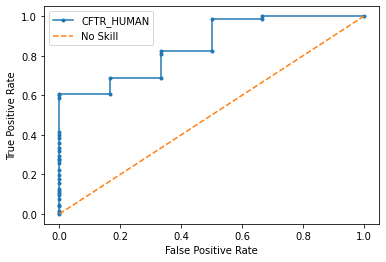

In [70]:
plt.plot(ls_fpr, ls_tpr, marker='.', label='CFTR_HUMAN')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

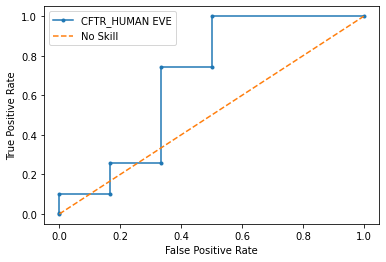

In [71]:
plt.plot(cs_fpr, cs_tpr, marker='.', label='CFTR_HUMAN EVE')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### DATA VISUALIZATION

In [73]:
length_2 = []
for i in range(len(AUC)): 
    length_2.append(length[AUC['pid'][i]])

In [74]:
AUC_for_visual2= AUC

In [75]:
AUC_for_visual2.insert(3, 'length', length_2)
AUC_for_visual2=AUC_for_visual2.sort_values('length')
AUC_for_visual2.index = [i for i in range(len(AUC))]

In [76]:
AUC_for_visual2

,pid,AUC EVE,AUC ind model,length,Difference
0,RP1_HUMAN,0.957143,0.928571,245,-0.028571
1,BBS10_HUMAN,0.892857,0.940476,256,0.047619
2,INF2_HUMAN,0.893678,0.916667,273,0.022989
3,KMT2B_HUMAN,1.000000,1.000000,328,0.000000
4,DESP_HUMAN,0.821429,0.921429,338,0.100000
...,...,...,...,...,...
349,SYNM_HUMAN,0.972222,0.944444,124543,-0.027778
350,ARSB_HUMAN,0.866667,0.810256,129144,-0.056410
351,TRY1_HUMAN,0.729167,0.604167,135477,-0.125000
352,GALNS_HUMAN,0.819728,0.670068,138058,-0.149660


In [77]:
prova4 = AUC_for_visual2[AUC_for_visual2['length']<1000]

In [78]:
len(prova4[prova4['AUC EVE']<=prova4['AUC ind model']])

29

In [79]:
len(prova4)

49

In [80]:
69/129

0.5348837209302325

In [82]:
mutation.to_excel(r'scores.xlsx', index = False)

## SPEARMAN CORRELATION

In [83]:
spearman_correlation = {}
for gene in g_names: 
    df = mutation[mutation['gene name'] == gene]
    a, b = stats.spearmanr(df['EVEscore'], df['score'])
    spearman_correlation[gene] = a

In [85]:
spearman_corr_to_insert=[]
for i in range(len(AUC)):
    spearman_corr_to_insert.append(spearman_correlation[AUC['pid'][i]])

In [86]:
AUC_for_visual3= AUC

In [87]:
AUC_for_visual3.insert(5, 'spearman correlation', spearman_corr_to_insert)

In [88]:
AUC_for_visual3.sort_values('spearman correlation', ascending = False)

,pid,AUC EVE,AUC ind model,length,Difference,spearman correlation
326,S52A3_HUMAN,1.000000,1.000000,1826,0.000000,0.991209
291,ITPR1_HUMAN,1.000000,1.000000,4716,0.000000,0.985294
338,CRX_HUMAN,1.000000,1.000000,1593,0.000000,0.984240
204,GARS_HUMAN,0.828125,0.789062,2545,-0.039062,0.983451
347,PCY1A_HUMAN,1.000000,1.000000,3122,0.000000,0.979021
...,...,...,...,...,...,...
44,BRCA1_BRCT_HUMAN,0.973354,0.710031,3257,-0.263323,0.321755
11,CO1A1_HUMAN,0.993375,0.995583,2501,0.002208,0.316943
0,FBN1_HUMAN,0.928438,0.832513,1926,-0.095925,0.289918
12,CO3A1_HUMAN,0.995890,0.987671,2498,-0.008219,0.272755


Highest spearman correlation are for genes S52A3_HUMAN and ITPR1_HUMAN

In [89]:
mutation[mutation['gene name'] == 'S52A3_HUMAN'].to_excel(r'S52A3_HUMAN_sp.xlsx', index = False)

mutation[mutation['gene name'] == 'ITPR1_HUMAN'].to_excel(r'ITPR1_HUMAN_sp.xlsx', index = False)

In [90]:
AUC_for_visual3 = AUC_for_visual3.sort_values('length')

In [91]:
AUC_for_visual3

,pid,AUC EVE,AUC ind model,length,Difference,spearman correlation
253,RP1_HUMAN,0.957143,0.928571,245,-0.028571,0.910526
256,BBS10_HUMAN,0.892857,0.940476,256,0.047619,0.833699
117,INF2_HUMAN,0.893678,0.916667,273,0.022989,0.886362
240,KMT2B_HUMAN,1.000000,1.000000,328,0.000000,0.858329
129,DESP_HUMAN,0.821429,0.921429,338,0.100000,0.742626
...,...,...,...,...,...,...
341,SYNM_HUMAN,0.972222,0.944444,124543,-0.027778,0.923077
112,ARSB_HUMAN,0.866667,0.810256,129144,-0.056410,0.848767
322,TRY1_HUMAN,0.729167,0.604167,135477,-0.125000,0.762637
99,GALNS_HUMAN,0.819728,0.670068,138058,-0.149660,0.851531


In [92]:
AUC_for_visual3['spearman correlation'].mean()

0.8289147003745907

In [93]:
AUC_for_visual3[AUC_for_visual3['spearman correlation']>0.5]

,pid,AUC EVE,AUC ind model,length,Difference,spearman correlation
253,RP1_HUMAN,0.957143,0.928571,245,-0.028571,0.910526
256,BBS10_HUMAN,0.892857,0.940476,256,0.047619,0.833699
117,INF2_HUMAN,0.893678,0.916667,273,0.022989,0.886362
240,KMT2B_HUMAN,1.000000,1.000000,328,0.000000,0.858329
129,DESP_HUMAN,0.821429,0.921429,338,0.100000,0.742626
...,...,...,...,...,...,...
341,SYNM_HUMAN,0.972222,0.944444,124543,-0.027778,0.923077
112,ARSB_HUMAN,0.866667,0.810256,129144,-0.056410,0.848767
322,TRY1_HUMAN,0.729167,0.604167,135477,-0.125000,0.762637
99,GALNS_HUMAN,0.819728,0.670068,138058,-0.149660,0.851531


In [94]:
AUC_for_visual3.to_excel(r'length_sp.xlsx', index = False)

## NEW SCORE

Scaling axis 

In [95]:
scaler = MinMaxScaler()
scaler.fit(mutation[['score']])
score_scaled = scaler.transform(mutation[['score']])

In [96]:
score_scaled[0][0]

0.9981170150349336

In [185]:
alphas = np.arange(0,1.1,0.1)

In [198]:
AUC_alphas = []
for i in range(len(alphas)): 
    a = alphas[i]
    new_score = []
    mutation_fake = mutation.drop('score combined', axis = 1)
    AUC_to_be = {}
    for i in range(len(mutation)): 
        new_score.append(a*score_scaled[i][0]+(1-a)*EVE_score_sc[i])
    
    mutation_fake.insert(8, 'score combined', new_score)
    for gene in g_names: 
        df = mutation_fake[mutation_fake['gene name']==gene]
        AUC_to_be[gene] = sklearn.metrics.roc_auc_score(list(df['ClinVar']), list(df['score combined']))
    AUC_alphas.append(np.array(list(AUC_to_be.values())).mean())

In [199]:
AUC_alphas

[0.9235499975395438,
 0.9260816280168959,
 0.9281474002459891,
 0.9277059127113685,
 0.9280634107514345,
 0.9270239676149457,
 0.9266059089298548,
 0.9241980926739901,
 0.9205951338080923,
 0.9156135998235277,
 0.9079010369889763]

In [202]:
list(alphas)

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

In [204]:
np.max(AUC_alphas)

0.9281474002459891

The max AUC is the one resulting from alpha = 0.2

In [97]:
new_score = []
EVE_score_sc = list(mutation['EVEscore'])
a = 0.2
for i in range(len(mutation)): 
    new_score.append(a*score_scaled[i][0]+(1-a)*EVE_score_sc[i])

In [99]:
mutation.insert(8, 'score combined', new_score)

In [100]:
mutation

,gene name,wt_aa,position,mt_aa,ClinVar,EVEscore,EVElabels,score,score combined
0,3BP2_HUMAN,V,27,M,benign,0.630466,benign,12.218294,0.703996
1,3BP2_HUMAN,R,56,C,benign,0.151390,benign,5.746085,0.253908
2,3BP2_HUMAN,R,80,Q,benign,0.622594,benign,12.234506,0.697866
3,3BP2_HUMAN,H,100,R,benign,0.616032,benign,12.230111,0.692571
4,3BP2_HUMAN,A,155,V,benign,0.127663,benign,5.035303,0.227588
...,...,...,...,...,...,...,...,...,...
16668,ZEB2_HUMAN,L,1113,M,benign,0.729841,uncertain,6.193989,0.721294
16669,ZEB2_HUMAN,P,1118,H,benign,0.772766,uncertain,3.801105,0.730927
16670,ZEB2_HUMAN,L,1151,P,benign,0.373573,benign,6.935022,0.443931
16671,ZEB2_HUMAN,I,1179,T,benign,0.128273,benign,2.154461,0.198331


In [101]:
mutation[mutation['gene name'] == 'ANR11_HUMAN']

,gene name,wt_aa,position,mt_aa,ClinVar,EVEscore,EVElabels,score,score combined
706,ANR11_HUMAN,E,76,K,pathogenic,0.566919,pathogenic,6.055726,0.589529
707,ANR11_HUMAN,R,92,Q,benign,0.666204,uncertain,12.155189,0.731935
708,ANR11_HUMAN,A,94,P,benign,0.129773,benign,1.145397,0.189112
709,ANR11_HUMAN,G,101,R,benign,0.650686,uncertain,5.657998,0.652436
710,ANR11_HUMAN,N,130,S,benign,0.708480,uncertain,12.181888,0.766031
...,...,...,...,...,...,...,...,...,...
802,ANR11_HUMAN,R,2512,Q,pathogenic,0.709540,pathogenic,12.149289,0.766543
803,ANR11_HUMAN,R,2512,W,pathogenic,0.682973,pathogenic,12.149289,0.745289
804,ANR11_HUMAN,E,2524,G,pathogenic,0.623383,pathogenic,12.140971,0.697531
805,ANR11_HUMAN,M,2601,L,benign,0.660909,uncertain,12.131378,0.727454


In [102]:
mutation[mutation['gene name'] == 'ANR11_HUMAN'].to_excel(r'prova.xlsx', index = False)

In [214]:
AUC_NEW = {}
for gene in g_names: 
    df = mutation[mutation['gene name']==gene]
    AUC_NEW[gene] = sklearn.metrics.roc_auc_score(list(df['ClinVar']), list(df['score combined']))

In [216]:
Combined_AUC = []
for gene in AUC['pid'].unique(): 
    Combined_AUC.append(AUC_NEW[gene])

In [217]:
AUC.insert(4, 'AUC combined', Combined_AUC)

In [218]:
AUC

,pid,AUC EVE,AUC ind model,length,AUC combined,Difference,spearman correlation
0,FBN1_HUMAN,0.928438,0.832513,1926,0.917487,-0.095925,0.289918
1,LDLR_HUMAN,0.985042,0.961285,4048,0.984612,-0.023757,0.634232
2,SCN1A_HUMAN,0.950460,0.951563,10632,0.959141,0.001103,0.665427
3,BRCA1_HUMAN,0.960608,0.934275,920,0.958735,-0.026333,0.902503
4,TSC2_HUMAN,0.906929,0.918342,2621,0.912862,0.011413,0.852126
...,...,...,...,...,...,...,...
349,KCNV2_HUMAN,1.000000,1.000000,16175,1.000000,0.000000,0.936364
350,SERA_HUMAN,0.666667,0.733333,23579,0.700000,0.066667,0.881818
351,ACTN2_HUMAN,1.000000,1.000000,4668,1.000000,0.000000,0.818182
352,ANTR2_HUMAN,0.933333,0.966667,1805,1.000000,0.033333,0.751710


In [219]:
AUC[AUC['AUC combined']>AUC['AUC EVE']]

,pid,AUC EVE,AUC ind model,length,AUC combined,Difference,spearman correlation
2,SCN1A_HUMAN,0.950460,0.951563,10632,0.959141,0.001103,0.665427
4,TSC2_HUMAN,0.906929,0.918342,2621,0.912862,0.011413,0.852126
5,MYH7_HUMAN,0.837767,0.875848,18733,0.845070,0.038080,0.843678
6,ABCA4_HUMAN,0.957672,0.956349,5072,0.962081,-0.001323,0.821949
7,BRCA2_HUMAN,0.905280,0.937888,467,0.919908,0.032609,0.866626
...,...,...,...,...,...,...,...
345,MTO1_HUMAN,0.628571,0.585714,38234,0.628571,-0.042857,0.942208
348,GPAA1_HUMAN,0.866667,1.000000,2113,0.900000,0.133333,0.845455
350,SERA_HUMAN,0.666667,0.733333,23579,0.700000,0.066667,0.881818
352,ANTR2_HUMAN,0.933333,0.966667,1805,1.000000,0.033333,0.751710


In [220]:
218/354

0.615819209039548

In [221]:
AUC['AUC combined'].mean()

0.9281474002459884

In [222]:
AUC['AUC EVE'].mean()

0.9235499975395428

In [224]:
AUC['AUC ind model'].mean()

0.907901036988976

In [225]:
AUC.to_excel(r'final_auc.xlsx', index = False)

# AUC OF OTHER MODELS

In [19]:
performance = pd.read_excel('Performance_all.xlsx')

In [23]:
AVERAGE_ALL = performance.loc[:, :'AUC_VEST4_score']

In [31]:
AVERAGE_ALL = AVERAGE_ALL.iloc[[3222]]

In [35]:
columns = []
for i in range(len(AVERAGE_ALL.columns)): 
    if AVERAGE_ALL.columns[i][:3] == 'AUC': 
        columns.append(AVERAGE_ALL.columns[i])

In [42]:
AVERAGE_ALL.loc[:, columns]

,AUC_EVE_scores,AUC_BayesDel_addAF_score,AUC_BayesDel_noAF_score,AUC_CADD_phred,AUC_CADD_phred_hg19,AUC_CADD_raw,AUC_CADD_raw_hg19,AUC_ClinPred_score,AUC_DANN_score,AUC_DEOGEN2_score,...,AUC_MutPred_score,AUC_MVP_score,AUC_Polyphen2_HDIV_score,AUC_Polyphen2_HVAR_score,AUC_PrimateAI_score,AUC_PROVEAN_score,AUC_REVEL_score,AUC_SIFT_score,AUC_SIFT4G_score,AUC_VEST4_score
3222,0.909569,0.970511,0.919286,0.889839,0.884267,0.89016,0.884498,0.97836,0.79344,0.884473,...,0.869434,0.864431,0.867995,0.886689,0.857324,0.872238,0.923357,0.874275,0.879263,0.92657


In [45]:
columns_new = ['AUC_EVE_scores',
 'AUC_CADD_phred',
 'AUC_DANN_score',
 'AUC_DEOGEN2_score',
 'AUC_FATHMM_score',
 'AUC_LIST-S2_score',
 'AUC_LRT_score',
 'AUC_MPC_score',
 'AUC_MutationAssessor_score',
 'AUC_MutationTaster_score',
 'AUC_MutPred_score',
 'AUC_Polyphen2_HDIV_score',
 'AUC_Polyphen2_HVAR_score',
 'AUC_PrimateAI_score',
 'AUC_PROVEAN_score',
 'AUC_SIFT_score']

In [46]:
len(columns_new)

16

In [47]:
AVERAGE_ALL.loc[:, columns_new]

,AUC_EVE_scores,AUC_CADD_phred,AUC_DANN_score,AUC_DEOGEN2_score,AUC_FATHMM_score,AUC_LIST-S2_score,AUC_LRT_score,AUC_MPC_score,AUC_MutationAssessor_score,AUC_MutationTaster_score,AUC_MutPred_score,AUC_Polyphen2_HDIV_score,AUC_Polyphen2_HVAR_score,AUC_PrimateAI_score,AUC_PROVEAN_score,AUC_SIFT_score
3222,0.909569,0.889839,0.79344,0.884473,0.721212,0.818951,0.779401,0.871234,0.871737,0.697765,0.869434,0.867995,0.886689,0.857324,0.872238,0.874275


In [66]:
columns_new.remove('pid')

In [69]:
columns_new.insert(0, 'pid')

In [70]:
performance_model = performance.loc[:,columns_new]

In [71]:
performance_model

,pid,AUC_EVE_scores,AUC_CADD_phred,AUC_DANN_score,AUC_DEOGEN2_score,AUC_FATHMM_score,AUC_LIST-S2_score,AUC_LRT_score,AUC_MPC_score,AUC_MutationAssessor_score,AUC_MutationTaster_score,AUC_MutPred_score,AUC_Polyphen2_HDIV_score,AUC_Polyphen2_HVAR_score,AUC_PrimateAI_score,AUC_PROVEAN_score,AUC_SIFT_score
0,1433G_HUMAN,1.000000,1.000000,0.500000,1.000000,1.000000,0.750000,0.500000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,0.250000,1.000000,1.000000
1,1433Z_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2A5D_HUMAN,1.000000,0.954545,1.000000,1.000000,0.909091,0.909091,0.750000,0.954545,1.000000,0.750000,0.454545,1.000000,0.909091,0.590909,1.000000,0.886364
3,2A5G_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2AAA_HUMAN,1.000000,1.000000,1.000000,1.000000,0.472222,0.777778,0.666667,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.777778,0.944444,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220,ZSWM6_HUMAN,0.833333,0.666667,0.666667,0.833333,0.500000,0.833333,1.000000,1.000000,1.000000,1.000000,NaN,0.750000,0.833333,1.000000,0.833333,0.666667
3221,All_proteins,0.885278,0.888454,0.766085,0.910335,0.792744,0.832745,0.795462,0.793285,0.869632,0.696542,0.896116,0.850209,0.877515,0.853201,0.885765,0.880723
3222,Average_proteins,0.909569,0.889839,0.793440,0.884473,0.721212,0.818951,0.779401,0.871234,0.871737,0.697765,0.869434,0.867995,0.886689,0.857324,0.872238,0.874275
3223,Weigthed_average_proteins,0.910460,0.891762,0.785373,0.893680,0.739736,0.827066,0.785334,0.864173,0.878185,0.698220,0.887278,0.867137,0.885697,0.866189,0.877719,0.884287


In [73]:
index = []
for i in range(len(performance_model)): 
    if performance_model['pid'][i] in g_names:
        index.append(i)
performance_model = performance_model.iloc[index, :]
performance_model.index = [i for i in range(len(performance_model))]

In [74]:
performance_model

,pid,AUC_EVE_scores,AUC_CADD_phred,AUC_DANN_score,AUC_DEOGEN2_score,AUC_FATHMM_score,AUC_LIST-S2_score,AUC_LRT_score,AUC_MPC_score,AUC_MutationAssessor_score,AUC_MutationTaster_score,AUC_MutPred_score,AUC_Polyphen2_HDIV_score,AUC_Polyphen2_HVAR_score,AUC_PrimateAI_score,AUC_PROVEAN_score,AUC_SIFT_score
0,3BP2_HUMAN,0.833333,0.653846,0.743590,0.782051,1.000000,NaN,0.769231,NaN,NaN,0.761905,0.760000,0.871795,0.884615,0.794872,0.858974,0.628205
1,A1AT_HUMAN,0.874074,0.833333,0.870370,0.859259,0.777778,NaN,0.559259,NaN,0.844444,NaN,0.810000,0.857407,0.862963,0.692593,0.814815,0.868519
2,A4_HUMAN,0.785714,0.651786,0.625000,0.946429,1.000000,0.714286,0.866071,0.821429,0.482143,NaN,0.714286,0.750000,1.000000,0.767857,0.750000,0.758929
3,ABCA3_HUMAN,0.825397,0.730159,0.571429,0.603175,0.365079,0.603175,0.714286,0.888889,1.000000,0.476190,0.250000,0.825397,0.817460,0.619048,0.825397,0.833333
4,ABCA4_HUMAN,0.957672,0.901896,0.890212,0.931658,0.641093,0.915123,0.817901,0.895723,0.934965,0.712827,0.825342,0.862434,0.891093,0.936949,0.957672,0.921958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,WDR62_HUMAN,1.000000,0.952381,0.825397,0.888889,0.714286,0.873016,0.936508,NaN,0.936508,0.500000,0.857143,0.968254,0.936508,0.952381,1.000000,0.952381
350,WFS1_HUMAN,0.983333,0.988333,0.936667,0.968889,0.791667,NaN,0.828333,NaN,0.928889,0.796111,0.952381,0.959444,0.971111,0.947778,0.972778,0.927222
351,WIPI4_HUMAN,0.962963,0.950617,0.950617,0.950617,0.209877,NaN,0.537037,NaN,0.950617,NaN,0.933333,0.901235,0.913580,0.888889,0.950617,0.975309
352,WN10A_HUMAN,0.950000,0.891667,0.766667,0.966667,0.991667,0.766667,0.925000,0.550000,0.950000,0.666667,1.000000,0.966667,0.983333,0.600000,0.950000,0.933333


In [78]:
average_model = {}
for column in columns_new: 
    if column == 'pid': 
        continue
    average_model[column] = np.average(performance_model[column].dropna())

In [79]:
average_model

{'AUC_EVE_scores': 0.9235499975395433,
 'AUC_CADD_phred': 0.9064848361867339,
 'AUC_DANN_score': 0.7838940280069102,
 'AUC_DEOGEN2_score': 0.9071570736230216,
 'AUC_FATHMM_score': 0.742744168040008,
 'AUC_LIST-S2_score': 0.8431934602904512,
 'AUC_LRT_score': 0.790751510064843,
 'AUC_MPC_score': 0.8843175709337762,
 'AUC_MutationAssessor_score': 0.885722723513622,
 'AUC_MutationTaster_score': 0.6983823009322838,
 'AUC_MutPred_score': 0.884233290193849,
 'AUC_Polyphen2_HDIV_score': 0.8792789520725851,
 'AUC_Polyphen2_HVAR_score': 0.9024275716439436,
 'AUC_PrimateAI_score': 0.8734500894775915,
 'AUC_PROVEAN_score': 0.8996322093288037,
 'AUC_SIFT_score': 0.8957290124974869}